In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn.functional as f
from pytorch_lightning import Trainer

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid
from torchsummary import summary

# from skimage.util import random_noise
from tqdm.notebook import tqdm
from functools import partial

In [5]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Quadro RTX 8000, 460.39, 48601 MiB
Quadro RTX 8000, 460.39, 48601 MiB
GeForce RTX 2080, 460.39, 7982 MiB
Quadro RTX 8000, 460.39, 48601 MiB
Quadro RTX 8000, 460.39, 48601 MiB
Quadro RTX 8000, 460.39, 48601 MiB
Quadro RTX 8000, 460.39, 48601 MiB
Quadro RTX 8000, 460.39, 48601 MiB


# Prepare Data

In [6]:
upscale = 4

height = (192  // upscale )
width = (192  // upscale )#128

In [7]:

transform = transforms.Compose([transforms.Resize((192,192)),
                                transforms.RandomRotation(degrees = 5),
                                transforms.RandomRotation(degrees = 10),
                                transforms.RandomRotation(degrees = 15),
                                transforms.RandomSolarize(threshold = 0.2),
                                transforms.ToTensor(), 
                                ]) 

transform_test = transforms.Compose([transforms.Resize((192,192)), 

                                transforms.ToTensor(), 
                                ]) 


In [11]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [12]:
import glob
class PreDataset(Dataset):
    def __init__(self, Input_dir, transform):
        self.Input_dir = Input_dir
        self.transform = transform
        self.Input_imgs = glob.glob(Input_dir)
    def __len__(self):
        return len(self.Input_imgs)
    def __getitem__(self, idx):
        In_img_loc = os.path.join(self.Input_dir, self.Input_imgs[idx])
        In_image = Image.open(In_img_loc).convert("RGB")
        IN_tensor = self.transform(In_image)

        return IN_tensor

In [13]:
# set train datasets
LP_data = PreDataset('/home/akoubaa/AI_projects/image_restoration/new_Architecture/train/*/*/*.*', transform = transform )

len(LP_data)

900

In [14]:
LP_train, LP_test = torch.utils.data.random_split(LP_data, [850, 50])#520

In [15]:
# create torch dataloaders
train_loader = DataLoader(LP_train, batch_size=2, shuffle=True)
test_loader = DataLoader(LP_test, batch_size=2, shuffle=True)
pl.seed_everything(42)

Global seed set to 42


42

In [16]:
# Create batch of the test images that we will use to visualize
input_images = next(iter(test_loader))

In [17]:
# to show images from the batch
def show_images(batch, number_to_show):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(batch.detach()[:number_to_show], nrow=8).permute(1, 2, 0))#denorm(

torch.Size([2, 3, 48, 48])


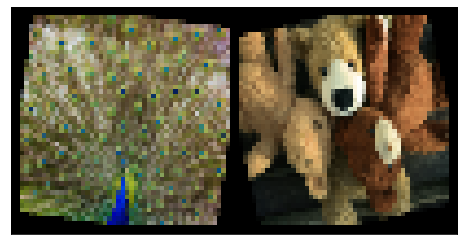

In [18]:
# LR images original images

def trans_LR(imgs):
    upscale = 4
    height = (imgs.shape[2]  // upscale)
    width = (imgs.shape[3]  // upscale )
    return transforms.Resize((height, width))(imgs)
LR_imgs = trans_LR(input_images)
show_images(LR_imgs, 4)
print(LR_imgs.shape)

torch.Size([2, 3, 192, 192])


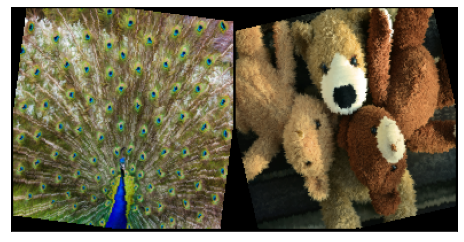

In [19]:
# original images
show_images(input_images, 4)
print(input_images.shape)

# 1-SwinIR Model

In [21]:
# !pip install timm

In [22]:
# -----------------------------------------------------------------------------------
# SwinIR: Image Restoration Using Swin Transformer, https://arxiv.org/abs/2108.10257
# Originally Written by Ze Liu, Modified by Jingyun Liang.
# -----------------------------------------------------------------------------------

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(pl.LightningModule):#nn.Module
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(pl.LightningModule):#nn.Module
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(pl.LightningModule):#nn.Module
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(pl.LightningModule):#nn.Module
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(pl.LightningModule):# nn.Module
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(pl.LightningModule):#nn.Module
    """Residual Swin Transformer Block (RSTB).
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(pl.LightningModule):#nn.Module
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(pl.LightningModule):#nn.Module
    r""" Image to Patch Unembedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):
    """Upsample module.
    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.
    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


class SwinIR(pl.LightningModule):#nn.Module
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.
    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=64, patch_size=1, in_chans=3,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            if self.upscale == 4:
                self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        H, W = x.shape[2:]
        x = self.check_image_size(x)
        
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            if self.upscale == 4:
                x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        return x[:, :, :H*self.upscale, :W*self.upscale]

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops

# Train Model

In [23]:

# check for gpu
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


# Frequancy loss with charboner loss + lablacian loss

In [25]:
# #New_Version
import torch
import torch.nn as nn

class GradualFrequencyLoss(nn.Module):
    def __init__(self, start_frequency = 10, end_frequency = 255, current_epoch = 100, num_epoch = 100, filter_apply = True):
        super(GradualFrequencyLoss, self).__init__()
        self.start_frequency = start_frequency
        self.end_frequency = end_frequency
        self.current_epoch = current_epoch
        self.num_epoch = num_epoch
        self.filter_apply = filter_apply
        self.eps = 1e-3
        self.best_loss = 100.0
        k = torch.Tensor([[.05, .25, .4, .25, .05]])
        self.kernel = torch.matmul(k.t(),k).unsqueeze(0).repeat(3,1,1,1)
        
    def forward(self, input, target, Current_epo):
        self.current_epoch = Current_epo
        Cut_off_frequency = self.start_frequency - (self.start_frequency - self.end_frequency) * self.current_epoch // self.num_epoch
        # Apply a high-pass filter to the input and target images to extract the high frequency component
        input_filtered = self.high_pass_filter(input, start = self.start_frequency, end = Cut_off_frequency, filter_apply = self.filter_apply)
        target_filtered = self.high_pass_filter(target, start = self.start_frequency, end = Cut_off_frequency, filter_apply = self.filter_apply)
        # Calculate the loss based on the difference between the filtered input and target images
        o_inp = input
        o_tar = target
        loss = self.calculate_loss(input_filtered, target_filtered, o_inp, o_tar)
        return loss
    
    def high_pass_filter(self, x, start = 10, end = 100, filter_apply = False):
        # Implement the high-pass filter here
        b, g, r = x[:,0], x[:,1], x[:,2]
        f_b = torch.fft.fft2(b, norm='ortho')
        f_g = torch.fft.fft2(g, norm='ortho')
        f_r = torch.fft.fft2(r, norm='ortho')
        # Shift the zero frequency component to the center of the spectrum
        fshift_b = f_b
        fshift_g = f_g
        fshift_r = f_r
        # Define the lower and upper cutoff frequencies for the bandpass filter
        low_cutoff = start
        high_cutoff = end  
        # Create a series of masks with increasing numbers of frequencies
        mask = torch.zeros_like(fshift_b, dtype=torch.float32)
        mask[:,:,:low_cutoff] = 1
        mask[:,:high_cutoff,:] = 1
        # Loop through the masks and display the filtered images
        # Apply the mask to the frequency spectrum of each color channel
        filtered_b = fshift_b * mask
        filtered_g = fshift_g * mask
        filtered_r = fshift_r * mask
        # Convert the filtered images to real values (since the inverse FFT returns complex values)
        filtered_image_b = filtered_b
        filtered_image_g = filtered_g
        filtered_image_r = filtered_r
        filtered_image_b = torch.stack([filtered_image_b.real, filtered_image_b.imag], 0)
        filtered_image_g = torch.stack([filtered_image_g.real, filtered_image_g.imag], 0)
        filtered_image_r = torch.stack([filtered_image_r.real, filtered_image_r.imag], 0)
        image_reconstructed = torch.stack((filtered_image_b, filtered_image_g, filtered_image_r), dim = 2)
        if filter_apply:
            image_reconstructed = filter(image_reconstructed)
        return image_reconstructed

    def conv_gauss(self, img):
        n_channels, _, kw, kh = self.kernel.shape
        img = F.pad(img, (kw//2, kh//2, kw//2, kh//2), mode='replicate')
        return F.conv2d(img.cpu(), self.kernel, groups=n_channels)
    
    def laplacian_kernel(self, current):
        filtered    = self.conv_gauss(current)    # filter
        down        = filtered[:,:,::2,::2]               # downsample
        new_filter  = torch.zeros_like(filtered)
        new_filter[:,:,::2,::2] = down*4                  # upsample
        filtered    = self.conv_gauss(new_filter) # filter
        diff = current.to(device) - filtered.to(device)
        return diff
    
    def calculate_loss(self, input, target, o_inp, o_tar):
        # Implement the loss calculation here
        laplacian_diff = self.laplacian_kernel(o_inp)- self.laplacian_kernel(o_tar)
        diff = input - target
        diff_ = o_inp - o_tar
        loss = torch.mean(torch.sqrt(( (diff * diff) + (diff_ * diff_) + (laplacian_diff * laplacian_diff) + (self.eps*self.eps) ))) 
        return loss

In [31]:
from torch.autograd import Variable
from torchmetrics import PeakSignalNoiseRatio
import pandas as pd
from torchmetrics.functional import structural_similarity_index_measure
# from torchmetrics.functional import peak_signal_noise_ratio
class Autoencoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.loss_pro = GradualFrequencyLoss(start_frequency = 10, end_frequency = 255, current_epoch = 1, num_epoch = 50, filter_apply = False)
        self.upsampler = 'pixelshuffle'
        self.upscale = 4
        self.window_size = 8
        self.height = (192 // self.upscale )
        self.width = (192 // self.upscale )
        self.model_1  = SwinIR(upscale=self.upscale, in_chans=3,
                    img_size=(self.height, self.width),
                    window_size=self.window_size,#Must width and hight divisible by window_size
                    img_range=1.,
                    depths=[6, 6, 6, 6, 6, 6],
                    embed_dim=180,
                    num_heads=[6, 6, 6, 6, 6, 6],
                    mlp_ratio=2,
                    upsampler = self.upsampler,
                    resi_connection='1conv')
        
        self.model_1.to(device)
        self.i_loss = 0.0
        self.list_PSNR = []
        self.list_SSIM = []
        self.best_PSNR = 0.0
        self.PSNR_Train = 0.0
      
        self.Test_i_loss = 0.0
        self.Test_list_PSNR = []
        self.Test_list_SSIM = []
        self.Test_best_PSNR = 0.0
        
        self.psnr_t = 0.0
        self.psnr = PeakSignalNoiseRatio()
    def forward(self, x):
        x_hat = self.model_1(x)
        return x_hat    

    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.0002)

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.2, 
                                                         patience=5, 
                                                         min_lr=5e-5)
        return {"optimizer": optimizer,
                "lr_scheduler": scheduler,
                "monitor": "val_loss"}
    
    def training_step(self, batch, batch_idx):
        x = batch
        x_lr = trans_LR(x)
        x_hat = self.model_1(x_lr)
        loss = self.loss_pro(x_hat, x, trainer.current_epoch)
        self.i_loss = loss.item()
        self.psnr_t = self.psnr(x_hat, x).item()
        self.list_PSNR.append(self.psnr_t)
        # Logging to TensorBoard by default        
        self.log('train_loss', loss)
        return loss

    
    def training_epoch_end(self, batch):
        print("####################################Training Results###################################")
        print("Train_loss ",self.i_loss)
        ###########################################
        self.PSNR_Train = (sum(self.list_PSNR) / len(self.list_PSNR))
        print("Train_PSNR ",self.PSNR_Train)

  
    
    def validation_step(self, batch, batch_idx):
        x = batch
        x_lr = trans_LR(x)
        x_hat = self.model_1(x_lr)
        loss = self.loss_pro(x_hat, x, trainer.current_epoch)
        self.Test_i_loss = loss.item()
        self.psnr_t = self.psnr(x_hat, x).item()
        self.Test_list_PSNR.append(self.psnr_t)
        
        # Logging to TensorBoard by default
        self.log('val_loss', loss)
        return loss
 
    def validation_epoch_end(self, batch):
        print("##################################Validation Results#####################################")
        print("Test_loss ",self.Test_i_loss)
        ###########################################
        self.PSNR_Train = (sum(self.Test_list_PSNR) / len(self.Test_list_PSNR))
        print("Test_PSNR ",self.PSNR_Train)

    def test_step(self, batch, batch_idx):
        x = batch
        x_lr = trans_LR(x)
        x_hat = self.model_1(x_lr)
        loss = self.loss_pro(x_hat, x, trainer.current_epoch)
        # Logging to TensorBoard by default
        self.log('test_loss', loss)
        return loss
model = Autoencoder()

In [32]:
print('#########################################################################################################################################################################')
print('Freq_Loss')
import time
start = time.time()
num_epoch = 100
batch = 8
LP_train, LP_test = torch.utils.data.random_split(LP_data, [850, 50])
# create torch dataloaders
train_loader = DataLoader(LP_train, batch_size=batch, shuffle=True)
test_loader = DataLoader(LP_test, batch_size=batch, shuffle=True)

trainer = Trainer(max_epochs = num_epoch,strategy= 'dp',
                  accelerator='gpu',
                  devices = [2],
                 log_every_n_steps = 4,)

trainer.fit(model, train_loader, test_loader)
end = time.time()
print(f"Runtime of model is {end - start} sec")

#########################################################################################################################################################################
Freq_Loss


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name     | Type                 | Params
--------------------------------------------------
0 | loss_pro | GradualFrequencyLoss | 0     
1 | model_1  | SwinIR               | 11.9 M
2 | psnr     | PeakSignalNoiseRatio | 0     
--------------------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params
47.601    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.26424896717071533
Test_PSNR  10.074580192565918


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.10053258389234543
Test_PSNR  16.935582902696396
####################################Training Results###################################
Train_loss  0.10460947453975677
Train_PSNR  17.127634636709622


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07268451154232025
Test_PSNR  18.385963678359985
####################################Training Results###################################
Train_loss  0.09365696460008621
Train_PSNR  18.34598378154719


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.12026232481002808
Test_PSNR  18.769922173541524
####################################Training Results###################################
Train_loss  0.0864957943558693
Train_PSNR  18.932845195877217


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.09026210755109787
Test_PSNR  19.0091038386027
####################################Training Results###################################
Train_loss  0.12450723350048065
Train_PSNR  19.30003223909396


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08315081894397736
Test_PSNR  19.30294686394769
####################################Training Results###################################
Train_loss  0.05305716022849083
Train_PSNR  19.579746647415874


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.0712084174156189
Test_PSNR  19.486389376900412
####################################Training Results###################################
Train_loss  0.08440528064966202
Train_PSNR  19.77549590797068


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.12967608869075775
Test_PSNR  19.576604693543675
####################################Training Results###################################
Train_loss  0.103938989341259
Train_PSNR  19.93392252317258


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07010188698768616
Test_PSNR  19.689182149952856
####################################Training Results###################################
Train_loss  0.08764027059078217
Train_PSNR  20.064943107489114


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.09790950268507004
Test_PSNR  19.797298020582932
####################################Training Results###################################
Train_loss  0.10121826827526093
Train_PSNR  20.167402205066146


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07568303495645523
Test_PSNR  19.893172793918186
####################################Training Results###################################
Train_loss  0.1089630126953125
Train_PSNR  20.26242250371202


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07687503099441528
Test_PSNR  19.9602755534498
####################################Training Results###################################
Train_loss  0.06762202084064484
Train_PSNR  20.348044620698655


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.0559832789003849
Test_PSNR  20.081179463586142
####################################Training Results###################################
Train_loss  0.06545031815767288
Train_PSNR  20.420834103848705


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.05936983972787857
Test_PSNR  20.16875539800172
####################################Training Results###################################
Train_loss  0.05497285723686218
Train_PSNR  20.486304354444844


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07842253148555756
Test_PSNR  20.22354814529419
####################################Training Results###################################
Train_loss  0.09352486580610275
Train_PSNR  20.55197812972941


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07222947478294373
Test_PSNR  20.264528363664574
####################################Training Results###################################
Train_loss  0.08229433745145798
Train_PSNR  20.611198599390523


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08587552607059479
Test_PSNR  20.29475729089034
####################################Training Results###################################
Train_loss  0.060492340475320816
Train_PSNR  20.659958696253945


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.04752292111515999
Test_PSNR  20.380240085696386
####################################Training Results###################################
Train_loss  0.08166743814945221
Train_PSNR  20.70585303545129


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07968543469905853
Test_PSNR  20.41546304523945
####################################Training Results###################################
Train_loss  0.06528373807668686
Train_PSNR  20.749685044353004


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07513752579689026
Test_PSNR  20.454930185388637
####################################Training Results###################################
Train_loss  0.07734254002571106
Train_PSNR  20.789272557440146


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.09482327103614807
Test_PSNR  20.488943570096726
####################################Training Results###################################
Train_loss  0.07828637212514877
Train_PSNR  20.825982371446127


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07342113554477692
Test_PSNR  20.525794880502175
####################################Training Results###################################
Train_loss  0.052164748311042786
Train_PSNR  20.86277005213019


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07159142196178436
Test_PSNR  20.566290439703526
####################################Training Results###################################
Train_loss  0.07508711516857147
Train_PSNR  20.896179466198944


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.05516953021287918
Test_PSNR  20.615141535097838
####################################Training Results###################################
Train_loss  0.10548675060272217
Train_PSNR  20.92997084590101


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07275805622339249
Test_PSNR  20.639236035066492
####################################Training Results###################################
Train_loss  0.09642952680587769
Train_PSNR  20.957450391718904


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.0697781965136528
Test_PSNR  20.663095291051487
####################################Training Results###################################
Train_loss  0.07120229303836823
Train_PSNR  20.98309982905878


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.0920620858669281
Test_PSNR  20.672985533009406
####################################Training Results###################################
Train_loss  0.06370077282190323
Train_PSNR  21.006622220868262


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.0778929591178894
Test_PSNR  20.701700100723986
####################################Training Results###################################
Train_loss  0.07163093984127045
Train_PSNR  21.029466648504535


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.1567593663930893
Test_PSNR  20.715822585905443
####################################Training Results###################################
Train_loss  0.10176600515842438
Train_PSNR  21.04938108835106


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07401462644338608
Test_PSNR  20.744145109595323
####################################Training Results###################################
Train_loss  0.060702886432409286
Train_PSNR  21.06984029598402


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08164586871862411
Test_PSNR  20.76085452313693
####################################Training Results###################################
Train_loss  0.09299588948488235
Train_PSNR  21.089226969603065


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.10303953289985657
Test_PSNR  20.761184361427343
####################################Training Results###################################
Train_loss  0.0840807855129242
Train_PSNR  21.110311349760096


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.06738044321537018
Test_PSNR  20.78884957743957
####################################Training Results###################################
Train_loss  0.06887611001729965
Train_PSNR  21.127738504487777


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07491110265254974
Test_PSNR  20.8109500213754
####################################Training Results###################################
Train_loss  0.0684783086180687
Train_PSNR  21.144884632113836


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.09238386899232864
Test_PSNR  20.825183717409768
####################################Training Results###################################
Train_loss  0.05758853256702423
Train_PSNR  21.16064948285917


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.10311148315668106
Test_PSNR  20.839725077393567
####################################Training Results###################################
Train_loss  0.055246733129024506
Train_PSNR  21.175658515807942


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.10521901398897171
Test_PSNR  20.846858865632786
####################################Training Results###################################
Train_loss  0.08981312811374664
Train_PSNR  21.19067404376631


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07128031551837921
Test_PSNR  20.86411879528528
####################################Training Results###################################
Train_loss  0.07449415326118469
Train_PSNR  21.201958757002085


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.10272529721260071
Test_PSNR  20.868453644994478
####################################Training Results###################################
Train_loss  0.0916944295167923
Train_PSNR  21.21460919795339


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07794208824634552
Test_PSNR  20.879836238514294
####################################Training Results###################################
Train_loss  0.08823131769895554
Train_PSNR  21.227790861543408


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.0825285091996193
Test_PSNR  20.89549575291627
####################################Training Results###################################
Train_loss  0.09519623219966888
Train_PSNR  21.23827576793243


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08781564980745316
Test_PSNR  20.910810912769147
####################################Training Results###################################
Train_loss  0.07258299738168716
Train_PSNR  21.25065343777248


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07662015408277512
Test_PSNR  20.92387706524617
####################################Training Results###################################
Train_loss  0.09493511915206909
Train_PSNR  21.260019484657047


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.11444234848022461
Test_PSNR  20.928831012335547
####################################Training Results###################################
Train_loss  0.07883516699075699
Train_PSNR  21.271268269000586


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08406365662813187
Test_PSNR  20.934612711014285
####################################Training Results###################################
Train_loss  0.059513822197914124
Train_PSNR  21.282764938997836


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08102323114871979
Test_PSNR  20.941417495535
####################################Training Results###################################
Train_loss  0.08032748848199844
Train_PSNR  21.294439551293046


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08453049510717392
Test_PSNR  20.94984851648778
####################################Training Results###################################
Train_loss  0.08692139387130737
Train_PSNR  21.305264288698062


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.0984126627445221
Test_PSNR  20.9618587321025
####################################Training Results###################################
Train_loss  0.06920450180768967
Train_PSNR  21.314843008641006


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07067125290632248
Test_PSNR  20.976574830049593
####################################Training Results###################################
Train_loss  0.07339981943368912
Train_PSNR  21.324315514334266


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.0963970497250557
Test_PSNR  20.984570494942044
####################################Training Results###################################
Train_loss  0.07433181256055832
Train_PSNR  21.333299650119137


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.058292537927627563
Test_PSNR  21.005284331061624
####################################Training Results###################################
Train_loss  0.08793140202760696
Train_PSNR  21.34194432606207


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.09217466413974762
Test_PSNR  21.006653676790116
####################################Training Results###################################
Train_loss  0.05427488684654236
Train_PSNR  21.351210774531268


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08416523784399033
Test_PSNR  21.012682503038416
####################################Training Results###################################
Train_loss  0.05938318371772766
Train_PSNR  21.360492373266982


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08169464021921158
Test_PSNR  21.020832982203917
####################################Training Results###################################
Train_loss  0.11624332517385483
Train_PSNR  21.369664482792057


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.11330512166023254
Test_PSNR  21.024996049780594
####################################Training Results###################################
Train_loss  0.08304736763238907
Train_PSNR  21.379149716384852


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.06302460283041
Test_PSNR  21.041871985107736
####################################Training Results###################################
Train_loss  0.1073751300573349
Train_PSNR  21.38699972773368


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.049891307950019836
Test_PSNR  21.061219481647317
####################################Training Results###################################
Train_loss  0.12491773813962936
Train_PSNR  21.394205323366997


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07730655372142792
Test_PSNR  21.067895694266532
####################################Training Results###################################
Train_loss  0.09276635944843292
Train_PSNR  21.403027607976735


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.06618435680866241
Test_PSNR  21.084862793193142
####################################Training Results###################################
Train_loss  0.08074958622455597
Train_PSNR  21.41198791552466


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.1070830300450325
Test_PSNR  21.09107563064759
####################################Training Results###################################
Train_loss  0.07170915603637695
Train_PSNR  21.42198126209947


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07312314212322235
Test_PSNR  21.101788778440646
####################################Training Results###################################
Train_loss  0.10172756016254425
Train_PSNR  21.430649824677225


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08174633234739304
Test_PSNR  21.11046670589136
####################################Training Results###################################
Train_loss  0.07620495557785034
Train_PSNR  21.438907593338016


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.0765787735581398
Test_PSNR  21.121753994478
####################################Training Results###################################
Train_loss  0.10001492500305176
Train_PSNR  21.445314647851667


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.09766001999378204
Test_PSNR  21.127332166409115
####################################Training Results###################################
Train_loss  0.06526459008455276
Train_PSNR  21.452786905124302


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08241688460111618
Test_PSNR  21.134937896728516
####################################Training Results###################################
Train_loss  0.0842936635017395
Train_PSNR  21.45941616399823


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.06839194893836975
Test_PSNR  21.14446298611764
####################################Training Results###################################
Train_loss  0.11646189540624619
Train_PSNR  21.466372227754462


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.09724730253219604
Test_PSNR  21.14683243735083
####################################Training Results###################################
Train_loss  0.06937847286462784
Train_PSNR  21.474109370794217


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08395932614803314
Test_PSNR  21.154894077600694
####################################Training Results###################################
Train_loss  0.09229538589715958
Train_PSNR  21.481310072595694


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.06821933388710022
Test_PSNR  21.16208210550093
####################################Training Results###################################
Train_loss  0.05745139718055725
Train_PSNR  21.488955434958577


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.06874096393585205
Test_PSNR  21.169337565628524
####################################Training Results###################################
Train_loss  0.09461867809295654
Train_PSNR  21.495863589752208


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08318524807691574
Test_PSNR  21.174287253279026
####################################Training Results###################################
Train_loss  0.10175224393606186
Train_PSNR  21.501329151173938


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.10281319916248322
Test_PSNR  21.176499039950016
####################################Training Results###################################
Train_loss  0.06143643334507942
Train_PSNR  21.507898124437734


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.06893125176429749
Test_PSNR  21.187026540281273
####################################Training Results###################################
Train_loss  0.08658169955015182
Train_PSNR  21.513640965380525


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.052254725247621536
Test_PSNR  21.197371867665073
####################################Training Results###################################
Train_loss  0.0644153282046318
Train_PSNR  21.5192784686779


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.09382849931716919
Test_PSNR  21.200508763239934
####################################Training Results###################################
Train_loss  0.07439498603343964
Train_PSNR  21.52535508551601


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.09152750670909882
Test_PSNR  21.204372340859226
####################################Training Results###################################
Train_loss  0.10393894463777542
Train_PSNR  21.5321270895747


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.09536221623420715
Test_PSNR  21.209597926907772
####################################Training Results###################################
Train_loss  0.08058694005012512
Train_PSNR  21.53863766307146


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.04953756555914879
Test_PSNR  21.223969891419472
####################################Training Results###################################
Train_loss  0.09302127361297607
Train_PSNR  21.5443541605158


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.12308908253908157
Test_PSNR  21.223853702962835
####################################Training Results###################################
Train_loss  0.07329138368368149
Train_PSNR  21.5503985529291


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.09810438007116318
Test_PSNR  21.225064121280706
####################################Training Results###################################
Train_loss  0.15577919781208038
Train_PSNR  21.55577458278196


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07807902246713638
Test_PSNR  21.22809676852515
####################################Training Results###################################
Train_loss  0.07937053591012955
Train_PSNR  21.561576773407303


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08946529775857925
Test_PSNR  21.232176215870727
####################################Training Results###################################
Train_loss  0.08471949398517609
Train_PSNR  21.568135182310364


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08949299156665802
Test_PSNR  21.234816561142605
####################################Training Results###################################
Train_loss  0.06775243580341339
Train_PSNR  21.57418616670722


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07775149494409561
Test_PSNR  21.236252976118188
####################################Training Results###################################
Train_loss  0.09813206642866135
Train_PSNR  21.578982715308165


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.11642342060804367
Test_PSNR  21.238605680304058
####################################Training Results###################################
Train_loss  0.05523240193724632
Train_PSNR  21.584335735547686


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.11238086223602295
Test_PSNR  21.24238920291664
####################################Training Results###################################
Train_loss  0.07533212006092072
Train_PSNR  21.58944067354711


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.06832554936408997
Test_PSNR  21.251074080435647
####################################Training Results###################################
Train_loss  0.0873873382806778
Train_PSNR  21.594725755265785


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.0708417221903801
Test_PSNR  21.25926315882007
####################################Training Results###################################
Train_loss  0.06347015500068665
Train_PSNR  21.59976796881573


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.06752477586269379
Test_PSNR  21.26696873637079
####################################Training Results###################################
Train_loss  0.08627354353666306
Train_PSNR  21.605345152248844


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.10222906619310379
Test_PSNR  21.271247540283202
####################################Training Results###################################
Train_loss  0.06753724068403244
Train_PSNR  21.61030622326275


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.0496978759765625
Test_PSNR  21.283107660993746
####################################Training Results###################################
Train_loss  0.07251818478107452
Train_PSNR  21.614979810407725


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.09407160431146622
Test_PSNR  21.28612074456491
####################################Training Results###################################
Train_loss  0.05945498123764992
Train_PSNR  21.620936343394916


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.10258236527442932
Test_PSNR  21.287671850930796
####################################Training Results###################################
Train_loss  0.05986883118748665
Train_PSNR  21.62681713834714


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.07424812018871307
Test_PSNR  21.292876440752156
####################################Training Results###################################
Train_loss  0.07917729020118713
Train_PSNR  21.63222878701171


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08084291219711304
Test_PSNR  21.30058865113692
####################################Training Results###################################
Train_loss  0.09213212877511978
Train_PSNR  21.6365202356461


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.13086988031864166
Test_PSNR  21.301700700705556
####################################Training Results###################################
Train_loss  0.09382152557373047
Train_PSNR  21.640599115881145


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.046156805008649826
Test_PSNR  21.314118306077905
####################################Training Results###################################
Train_loss  0.0578368678689003
Train_PSNR  21.645219021218587


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.10471466183662415
Test_PSNR  21.316048351853606
####################################Training Results###################################
Train_loss  0.09191431850194931
Train_PSNR  21.64923245025423


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.05003342032432556
Test_PSNR  21.322912363118903
####################################Training Results###################################
Train_loss  0.0831713080406189
Train_PSNR  21.65389325203569


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.08785431832075119
Test_PSNR  21.326473606576165
####################################Training Results###################################
Train_loss  0.11379344761371613
Train_PSNR  21.658439347688397


Validation: 0it [00:00, ?it/s]

##################################Validation Results#####################################
Test_loss  0.0677439495921135
Test_PSNR  21.33226290863124
####################################Training Results###################################
Train_loss  0.09116914868354797
Train_PSNR  21.66228134467223


`Trainer.fit` stopped: `max_epochs=100` reached.


Runtime of model is 19271.165395975113 sec


In [33]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.08303067833185196
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.08303067833185196}]

In [35]:
from torchmetrics import PeakSignalNoiseRatio
from torchmetrics import StructuralSimilarityIndexMeasure
ssim = StructuralSimilarityIndexMeasure()
psnr = PeakSignalNoiseRatio()

def Rev_trans_LR(imgs):
    upscale = 4
    height = (imgs.shape[2]  * upscale)
    width = (imgs.shape[3]  * upscale )
    return transforms.Resize((height, width))(imgs)

def visualize_reconstructions(model, input_imgs, num_test_img):
    # Reconstruct images
    input_imgs_ = trans_LR(input_imgs)
    start = time.time()
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs_.to(model.device))#model.
    reconst_imgs = reconst_imgs.cpu()
    end = time.time()
    print(f"Runtime of {num_test_img} Test image is {end - start} sec")
    print("time of one image is {} sec".format((end - start)/input_imgs.shape[0]))
    print("The average PSNR of {} images are {} dB".format(input_imgs.shape[0], psnr(reconst_imgs, input_imgs).numpy()))
    print("The average SSIM of {} images are {} ".format(input_imgs.shape[0], ssim(reconst_imgs, input_imgs).numpy()))
    # Plotting
    imgs = torch.stack([input_imgs, Rev_trans_LR(input_imgs_), reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs[0:9], nrow=3, normalize=True,value_range=(0, 1))#range=(-1, 1)
    grid = grid.permute(1, 2, 0)
    
    plt.figure(figsize=(18, 24))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()
    return reconst_imgs, input_imgs
# function to add some noise to images
import glob
import time

def calculate_Matrix():
    def get_train_images(num):
        return torch.stack([test_LP[i] for i in range(num)], dim=0)#[0]
    numbe_of_Images = glob.glob('/home/akoubaa/AI_projects/image_restoration/new_Architecture/BSD100/*.jpg')
    test_LP= PreDataset('/home/akoubaa/AI_projects/image_restoration/new_Architecture/BSD100/*.jpg', transform=transform_test)
    num_test_img = 100
    input_imgs = get_train_images(num_test_img)
    re_imgs, imgs = visualize_reconstructions(model, input_imgs, num_test_img)

Runtime of 100 Test image is 29.304361581802368 sec
time of one image is 0.2930436158180237 sec
The average PSNR of 100 images are 24.54095458984375 dB
The average SSIM of 100 images are 0.7616651654243469 


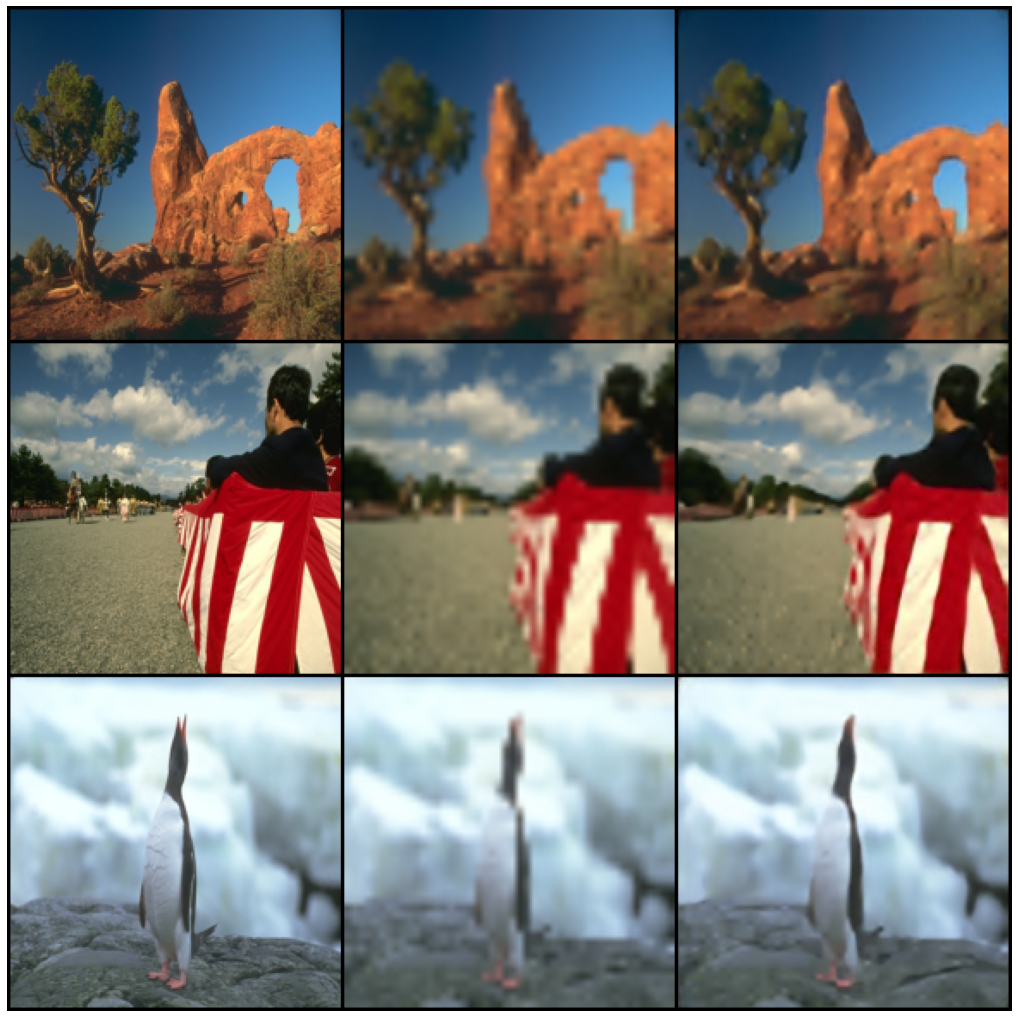

In [36]:
calculate_Matrix()